# Overfitting and underfitting

Taken from: https://scikit-learn.org/stable/modules/learning_curve.html

This example demonstrates the problems of underfitting and overfitting
and how we can use linear regression with polynomial features to 
approximate nonlinear functions. The plot shows the function that we 
want to approximate, which is a part of the cosine function. In 
addition, the samples from the real function and the approximations
of different models are displayed. The models have polynomial features
of different degrees. We can see that a linear function (polynomial
with degree 1) is not sufficient to fit the training samples. 
This is called underfitting. A polynomial of degree 4 approximates 
the true function almost perfectly. However, for higher degrees the 
model will overfit the training data, i.e. it learns the noise of the
training data. We evaluate quantitatively overfitting / underfitting
by using cross-validation. We calculate the mean squared error (MSE)
on the validation set, the higher, the less likely the model generalizes
correctly from the training data.


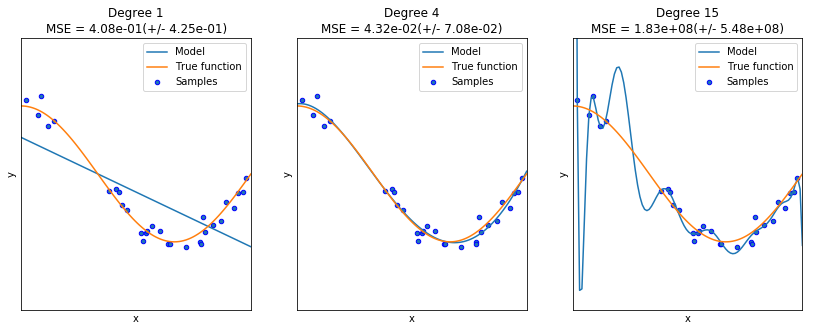

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

# Validation curves: plotting scores to evaluate models

Every estimator has its advantages and drawbacks. Its generalization error can be decomposed in terms of bias, variance and noise. The bias of an estimator is its average error for different training sets. The variance of an estimator indicates how sensitive it is to varying training sets. Noise is a property of the data.

In the above plot, we see a function f(x)=cos((3/2) * pi * x)
and some noisy samples from that function. We use three different estimators to fit the function: linear regression with polynomial features of degree 1, 4 and 15. We see that the first estimator can at best provide only a poor fit to the samples and the true function because it is too simple (high bias), the second estimator approximates it almost perfectly and the last estimator approximates the training data perfectly but does not fit the true function very well, i.e. it is very sensitive to varying training data (high variance).

Bias and variance are inherent properties of estimators and we usually have to select learning algorithms and hyperparameters so that both bias and variance are as low as possible. Another way to reduce the variance of a model is to use more training data. However, you should only collect more training data if the true function is too complex to be approximated by an estimator with a lower variance.

In the simple one-dimensional problem that we have seen in the example it is easy to see whether the estimator suffers from bias or variance. However, in high-dimensional spaces, models can become very difficult to visualize. For this reason, it is often helpful to use the tools described below.

## Validation curve

To validate a model we need a scoring function, for example accuracy for classifiers. The proper way of choosing multiple hyperparameters of an estimator are of course grid search or similar methods that select the hyperparameter with the maximum score on a validation set or multiple validation sets. Note that if we optimized the hyperparameters based on a validation score the validation score is biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization we have to compute the score on another test set.

However, it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

The function *validation_curve* can help in this case:

In [18]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

np.random.seed(0)
iris = load_iris()
X, y = iris.data, iris.target
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

train_scores, valid_scores = validation_curve(Ridge(), X, y, "alpha",
                                              np.logspace(-7, 3, 3),
                                              cv=5)
print("TrainScores:")
print(train_scores)            


print("ValidationScores:")
print(valid_scores)           


TrainScores:
[[0.93402178 0.94366418 0.92648383 0.91933313 0.92922507]
 [0.9340217  0.94366412 0.92648377 0.91933304 0.929225  ]
 [0.51143526 0.52415737 0.49868907 0.47086988 0.49623503]]
ValidationScores:
[[0.9055033  0.84185935 0.94569793 0.96231017 0.93366144]
 [0.90550088 0.84184574 0.94568969 0.96233172 0.93366806]
 [0.46706558 0.25698974 0.50496293 0.49826404 0.52500014]]


If the training score and the validation score are both low, the estimator will be underfitting. If the training score is high and the validation score is low, the estimator is overfitting and otherwise it is working very well. A low training score and a high validation score is usually not possible. All three cases can be found in the plot in the next subsection where we vary the parameter gamma of an SVM on the digits dataset.

### Plotting Validation curves

In this plot you can see the training scores and validation scores of an SVM for different values of the kernel parameter gamma. For very low values of gamma, you can see that both the training score and the validation score are low. This is called underfitting. Medium values of gamma will result in high values for both scores, i.e. the classifier is performing fairly well. If gamma is too high, the classifier will overfit, which means that the training score is good but the validation score is poor.

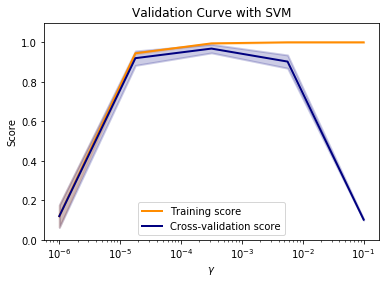

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


## Learning Curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data. In the *first* plot of the following subsection you can see an example: naive Bayes roughly converges to a low score.

We will probably have to use an estimator or a parametrization of the current estimator that can learn more complex concepts (i.e. has a lower bias). If the training score is much greater than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization. In the *second* plot of the following subsection you can see that the SVM could benefit from more training examples.

We can use the function learning_curve to generate the values that are required to plot such a learning curve (number of samples that have been used, the average scores on the training sets and the average scores on the validation sets):

In [21]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

train_sizes, train_scores, valid_scores = learning_curve(
    SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)
train_sizes            

print("TrainScores:")
print(train_scores)            


print("ValidationScores:")
print(valid_scores)    

TrainScores:
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
ValidationScores:
[[0.90384615 0.73480663 0.75487465 0.8907563  0.76338028]
 [0.88461538 0.71270718 0.77715877 0.88795518 0.8056338 ]
 [0.88461538 0.74309392 0.81615599 0.91036415 0.82535211]]


### Plotting Learning Curves

On the left side the learning curve of a naive Bayes classifier is shown for the digits dataset. Note that the training score and the cross-validation score are both not very good at the end. However, the shape of the curve can be found in more complex datasets very often: the training score is very high at the beginning and decreases and the cross-validation score is very low at the beginning and increases. On the right side we see the learning curve of an SVM with RBF kernel. We can see clearly that the training score is still around the maximum and the validation score could be increased with more training samples.

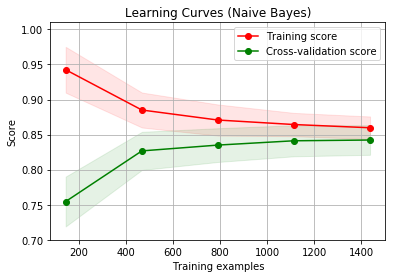

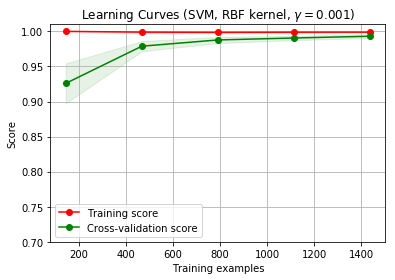

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()
